In [2]:
import os
import glob
import numpy as np 
import pandas as pd 
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from lightgbm import LGBMRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.metrics import mean_pinball_loss

from sklearn.model_selection import train_test_split
import matplotlib.ticker as ticker
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
import re
from sklearn.model_selection import GridSearchCV

In [3]:
# Loading the Datasets
filepath = 'data/schemas/warm_up/'

# Building information
b_1 = pd.read_csv(filepath + 'Building_1.csv')
b_2 = pd.read_csv(filepath + 'Building_2.csv')
b_3 = pd.read_csv(filepath + 'Building_3.csv')

# Other information
carbon_int = pd.read_csv(filepath + 'carbon_intensity.csv')
pricing    = pd.read_csv(filepath + 'pricing.csv')
weather    = pd.read_csv(filepath + 'weather.csv')

# Building level combine the dfs
comb_b_1 = pd.concat([b_1.reset_index(drop=True),
                      carbon_int.reset_index(drop=True),
                      pricing.reset_index(drop=True),
                      weather.reset_index(drop=True)], axis=1)

comb_b_2 = pd.concat([b_2.reset_index(drop=True),
                      carbon_int.reset_index(drop=True),
                      pricing.reset_index(drop=True),
                      weather.reset_index(drop=True)], axis=1)

comb_b_3 = pd.concat([b_3.reset_index(drop=True),
                      carbon_int.reset_index(drop=True),
                      pricing.reset_index(drop=True),
                      weather.reset_index(drop=True)], axis=1)

# Make a list of the buildings
b_list = [comb_b_1,comb_b_2,comb_b_3]

In [4]:
print(len(comb_b_1.columns))


36


In [5]:
# Fix the titles
b_list_clear = []

for b in b_list:
    regex = re.compile(r"\[|\]|<", re.IGNORECASE)
    b.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in b.columns.values]
    b_list_clear.append(b)

In [5]:
# General Outputs: 
# Building  Level: Cooling Load (kWh) ; DHW Load (kWh) ; Equipment Electric Power (kWh ; non-shiftable)
# Neighbour Level: Carbon Intensity (kgCO2e/kWh) ; Solar Generation (W/kW)

c_l_r = []
dhw_l = []
eep   = []


# Input information = 48 Steps
lag  = 48
step = 1


lgb_params = {
    'n_jobs': 1,
    'max_depth': 4,
    'min_data_in_leaf': 10,
    'subsample': 0.9,
    'n_estimators': 80,
    'learning_rate': 0.1,
    'colsample_bytree': 0.9,
    'boosting_type': 'gbdt',
    'verbose':-1,
    'steps':step,
}

In [9]:
# LightGBM Models (Hyperparameter Tuning)

# Generating the LightGBM

def LightGBM_Model(X_train, X_test, y_train, y_test):

    params = {
        'max_depth':        [3, 4, 5],
        'num_leaves':       [10, 15, 20],
        'learning_rate':    [0.05, 0.1, 0.15],
        'n_estimators':     [50, 100, 200],
        'subsample':        [0.5, 0.7, 0.9],
        'colsample_bytree': [0.5, 0.7, 0.9],
        'reg_alpha':        [0.01, 0.1, 1],
        'reg_lambda':       [0.01, 0.1, 1],
        'verbose':[-1]
    }
    
    lgb_mean = LGBMRegressor(boosting_type='gbdt', objective='regression')
    grid_search_mean = GridSearchCV(lgb_mean, params, cv=5, n_jobs=-1)
    grid_search_mean.fit(X_train, y_train)
        
    y_pred_mean  = grid_search_mean.predict(X_test)
    
    # Generate the df
    df = pd.DataFrame(
        {'Actual Value': y_test,
         'Predicted Value': y_pred_mean
        })
     
    return df, lgb_mean


In [ ]:
# 1.) Cooling Load (kWh)
i = 1
for b in b_list_clear:
    
    # Generate the x,y
    X = b
    y = b['Cooling Load (kWh)']

    # Generate the test,train 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)
    
    df, lgb = LightGBM_Model(X_train, X_test, y_train, y_test)
    c_l_r.append(df)
    
    # save the models
    lgb.booster_.save_model('my_models/models/cooling_load_model_b'+str(i)+'.txt')
    i = i + 1


In [ ]:
# 2.) DHW Load (kWh)
i = 1
for b in b_list_clear:
    
    # Generate the x,y
    X = b
    y = b['DHW Heating (kWh)']

    # Generate the test,train 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)
    
    df, lgb = LightGBM_Model(X_train, X_test, y_train, y_test)

    dhw_l.append(df)
    
    # save the models
    lgb.booster_.save_model('my_models/models/dhw_load_model_b'+str(i)+'.txt')
    i = i + 1

In [ ]:
# 3.) Equipment Electric Power (kWh)
i = 1
for b in b_list_clear:
    
    # Generate the x,y
    X = b
    y = b['Equipment Electric Power (kWh)']

    # Generate the test,train 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)
    
    df, lgb = LightGBM_Model(X_train, X_test, y_train, y_test)

    eep.append(df)
    
    # save the models
    lgb.booster_.save_model('my_models/models/Equipment_Electric_Power_model_b'+str(i)+'.txt')
    i = i + 1

In [ ]:
# Neighbour Level: Carbon Intensity (kgCO2e/kWh) ; Solar Generation (W/kW)

# 1.) Carbon Intensity (kgCO2e/kWh)
ci = []

# combine the datasets to one since we only have one CI 
comb = pd.concat([b_list_clear[0].reset_index(drop=True),
                  b_list_clear[1].reset_index(drop=True),
                  b_list_clear[2].reset_index(drop=True)])
    
# Generate the x,y
X = comb
y = comb['kg_CO2/kWh']

# Generate the test,train 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)
    
df, lgb = LightGBM_Model(X_train, X_test, y_train, y_test)

ci.append(df)

# save the models
lgb.booster_.save_model('my_models/models/Carbon_Intensity_Power_model.txt')

In [ ]:
# 3.) Solar Generation (W/kW)
sg = []
i = 1

for b in b_list_clear:

    # Generate the x,y
    X = b
    y = b['Solar Generation (W/kW)']

    # Generate the test,train 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)
    
    df, lgb = LightGBM_Model(X_train, X_test, y_train, y_test)
    sg.append(df)
    
    # save the models
    lgb.booster_.save_model('my_models/models/solar_generation_model_b'+str(i)+'.txt')
    i = i + 1

## Feature Selection

Feature: Cooling Load (kWh) Score: 5.32243893838286
Feature: Hour Score: 0.30689699459503794
Feature: Outdoor Drybulb Temperature (C) Score: 0.2564403790849381
Feature: Outdoor Relative Humidity (%) Score: 0.19621680508385664
Feature: 6h Direct Solar Radiation (W/m2) Score: 0.14954988044981032
Feature: Average Unmet Cooling Setpoint Difference (C) Score: 0.1445618162650164
Feature: Indoor Temperature (C) Score: 0.1443449015197653
Feature: 6h Diffuse Solar Radiation (W/m2) Score: 0.13064374730024353
Feature: Indoor Relative Humidity (%) Score: 0.12747537785238094
Feature: Temperature Set Point (C) Score: 0.12012898750339307
Feature: 6h Outdoor Drybulb Temperature (C) Score: 0.11415289911640336
Feature: 6h Outdoor Relative Humidity (%) Score: 0.1112484657677717
Feature: 12h Outdoor Drybulb Temperature (C) Score: 0.09752133386859851
Feature: 24h Outdoor Drybulb Temperature (C) Score: 0.0951611328858526
Feature: kg_CO2/kWh Score: 0.07756225937994721
Feature: Solar Generation (W/kW) Score: 

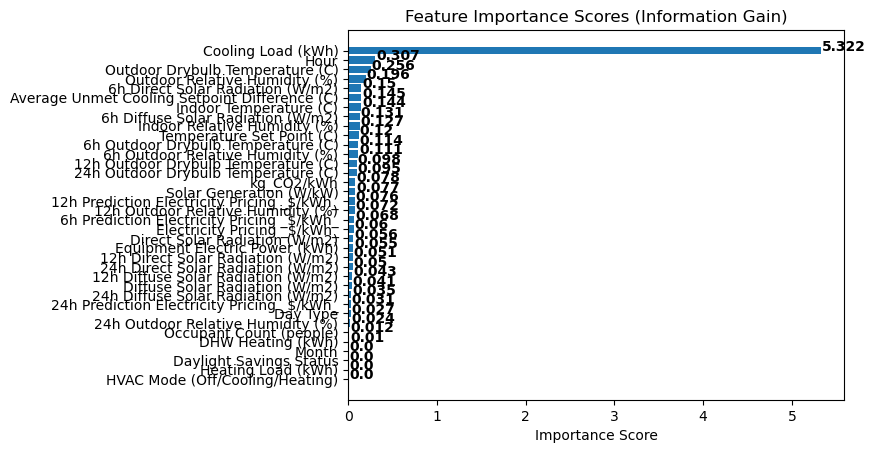

Feature: Cooling Load (kWh) Score: 5.086490228158893
Feature: Outdoor Drybulb Temperature (C) Score: 0.8177978424992323
Feature: Outdoor Relative Humidity (%) Score: 0.724453272350114
Feature: Hour Score: 0.6970808470560796
Feature: Average Unmet Cooling Setpoint Difference (C) Score: 0.619786810221366
Feature: 24h Outdoor Drybulb Temperature (C) Score: 0.5030276431806371
Feature: Equipment Electric Power (kWh) Score: 0.4320968829356713
Feature: Solar Generation (W/kW) Score: 0.3597383749618306
Feature: 12h Outdoor Drybulb Temperature (C) Score: 0.35066700895743974
Feature: Direct Solar Radiation (W/m2) Score: 0.326925525166188
Feature: 24h Outdoor Relative Humidity (%) Score: 0.2728600726843857
Feature: Indoor Temperature (C) Score: 0.2677967013251292
Feature: 12h Diffuse Solar Radiation (W/m2) Score: 0.26703592374023133
Feature: Diffuse Solar Radiation (W/m2) Score: 0.258457790817737
Feature: 24h Diffuse Solar Radiation (W/m2) Score: 0.24340917420976993
Feature: 6h Outdoor Drybulb Te

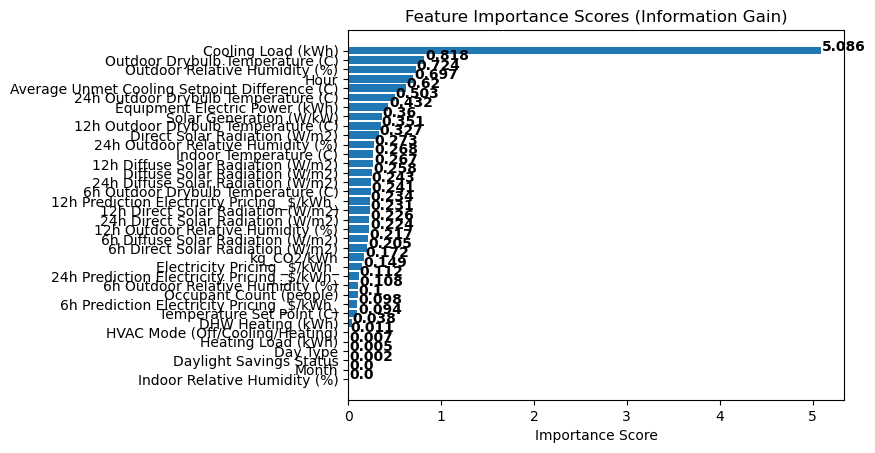

Feature: Cooling Load (kWh) Score: 5.322438938382859
Feature: Hour Score: 0.7625841095811183
Feature: Outdoor Drybulb Temperature (C) Score: 0.7271287138765663
Feature: Outdoor Relative Humidity (%) Score: 0.581045521322523
Feature: Equipment Electric Power (kWh) Score: 0.45479673550045474
Feature: 24h Outdoor Drybulb Temperature (C) Score: 0.44820960611303473
Feature: 12h Outdoor Drybulb Temperature (C) Score: 0.346511278926684
Feature: 6h Diffuse Solar Radiation (W/m2) Score: 0.2970083243373285
Feature: 24h Outdoor Relative Humidity (%) Score: 0.2889566569761386
Feature: Solar Generation (W/kW) Score: 0.2873523653549781
Feature: 6h Direct Solar Radiation (W/m2) Score: 0.25985895951034443
Feature: kg_CO2/kWh Score: 0.22080141743695103
Feature: 12h Outdoor Relative Humidity (%) Score: 0.22028813694356986
Feature: Diffuse Solar Radiation (W/m2) Score: 0.19099394582156837
Feature: Direct Solar Radiation (W/m2) Score: 0.19000514856902084
Feature: 12h Prediction Electricity Pricing _$/kWh_

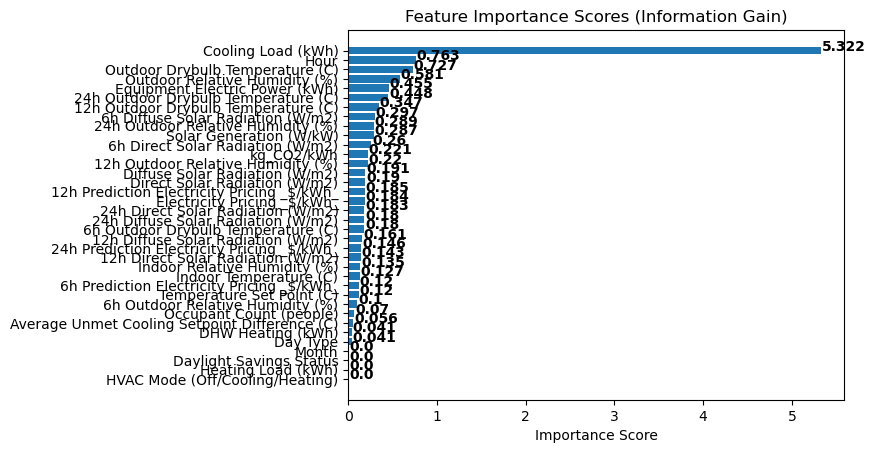

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.feature_selection import mutual_info_regression



for data in b_list_clear:

    # Split the dataset into features and target
    X = data
    y = data['Cooling Load (kWh)']

    # Apply Information Gain
    ig = mutual_info_regression(X, y)

    # Create a dictionary of feature importance scores
    feature_scores = {}
    i = 0
    for (columnName, columnData) in data.iteritems():
        feature_scores[columnName] = ig[i]
        i = i + 1
    # Sort the features by importance score in descending order
    sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

    # Print the feature importance scores and the sorted features
    for feature, score in sorted_features:
        print("Feature:", feature, "Score:", score)
    # Plot a horizontal bar chart of the feature importance scores
    fig, ax = plt.subplots()
    y_pos = np.arange(len(sorted_features))
    ax.barh(y_pos, [score for feature, score in sorted_features], align="center")
    ax.set_yticks(y_pos)
    ax.set_yticklabels([feature for feature, score in sorted_features])
    ax.invert_yaxis()  # Labels read top-to-bottom
    ax.set_xlabel("Importance Score")
    ax.set_title("Feature Importance Scores (Information Gain)")

    # Add importance scores as labels on the horizontal bar chart
    for i, v in enumerate([score for feature, score in sorted_features]):
        ax.text(v + 0.01, i, str(round(v, 3)), color="black", fontweight="bold")
    plt.show()